## Install gradio for visualization

In [1]:
!pip install -q gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 10.6 

## Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Dense
from keras.models import Sequential
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import gradio

## Connect to Google Drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Read all files and concatenate into single dataframe

In [4]:
data_dir = '/content/drive/MyDrive/Datasets/fonts'
csv_files = !ls "{data_dir}"/*.csv
csv_files = [file.strip() for file in csv_files]
csv_files = csv_files[:len(csv_files)//2]

In [5]:
dfs = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dfs, ignore_index=True)

In [6]:
df.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,AGENCY,AGENCY FB,64258,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
1,AGENCY,AGENCY FB,64257,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
2,AGENCY,AGENCY FB,61442,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
3,AGENCY,AGENCY FB,61441,0.4,0,0.0,35,21,51,22,...,1,1,1,1,1,1,163,255,255,255
4,AGENCY,AGENCY FB,9674,0.4,0,0.0,51,21,33,25,...,255,132,1,1,1,1,1,1,1,1


## Extract features and labels from dataframe

In [7]:
features = df.iloc[:, 12:].values
labels = df['font'].values

## Plot some pictures from dataset

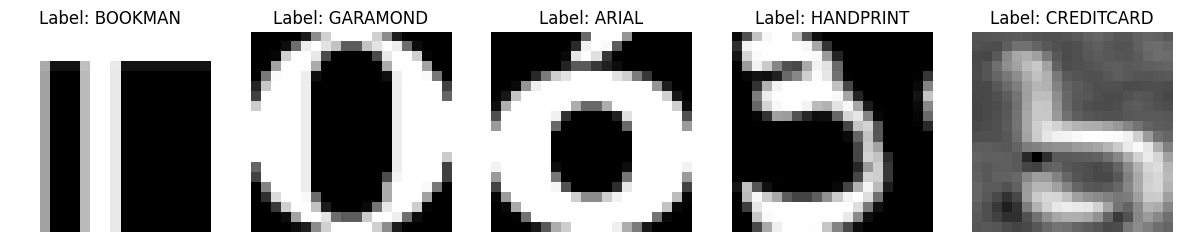

In [8]:
num_examples_to_show = 5

random_indices = np.random.choice(len(features), num_examples_to_show, replace=False)
plt.figure(figsize=(15, 3))

for i, idx in enumerate(random_indices, 1):
    image_data = features[idx].reshape(20, 20)
    label = df['font'][idx]

    plt.subplot(1, num_examples_to_show, i)
    plt.imshow(image_data, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.show()

## Set encoder for labels, normalise values to (0, 1) range, split the data to train and test

In [9]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

features = features.astype(np.float64) / 255.0

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Reshape the data from 400 values to 20*20 array for convolutional layers usage

In [10]:
X_train = X_train.reshape(-1, 20, 20, 1)
X_test = X_test.reshape(-1, 20, 20, 1)

## Build the model
We are using 3 convolutional layers with 64, 128 and 64 filters respectively, with 3x3 kernels, and also trying to use 3 MaxPooling layers. After flatten layer, here we also use 5 dense layers with 512, 1024, 512, 256 and 128 neurons respectively, followed by 0.4 dropout (except the first layer), and output layer with number of classes (76) neurons.
As an optimizer we are using ADAM with 0.001 learning rate and minimize sparse Cross-Entropy loss. Also we are using early stopping with 5 level patience to wait a little bit less time when learning. Model is learning during 30 epochs and using batch size 128.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(64, (3,3), activation='relu', input_shape=(20, 20, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(20, 20, 1), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/30
1708/1708 [==============================] - 28s 9ms/step - loss: 2.2148 - accuracy: 0.4475 - val_loss: 1.8441 - val_accuracy: 0.5137
Epoch 2/30
1708/1708 [==============================] - 14s 8ms/step - loss: 1.7623 - accuracy: 0.5318 - val_loss: 1.6233 - val_accuracy: 0.5592
Epoch 3/30
1708/1708 [==============================] - 15s 9ms/step - loss: 1.5907 - accuracy: 0.5663 - val_loss: 1.5237 - val_accuracy: 0.5834
Epoch 4/30
1708/1708 [==============================] - 14s 8ms/step - loss: 1.4711 - accuracy: 0.5946 - val_loss: 1.4157 - val_accuracy: 0.6096
Epoch 5/30
1708/1708 [==============================] - 15s 9ms/step - loss: 1.3835 - accuracy: 0.6157 - val_loss: 1.3811 - val_accuracy: 0.6188
Epoch 6/30
1708/1708 [==============================] - 15s 9ms/step - loss: 1.3148 - accuracy: 0.6321 - val_loss: 1.3129 - val_accuracy: 0.6367
Epoch 7/30
1708/1708 [==============================] - 14s 8ms/step - loss: 1.2587 - accuracy: 0.6460 - val_loss: 1.3053 - val_ac

## We use gradio to add some interface for more convenient predictions.
`predict_fonts` function is used to receive some input and return corresponding output, and the interface is defined with `gradio.Interface` class.

In [12]:
def predict_fonts(img):
  im = img.reshape(-1, 20, 20, 1) / 255.0
  prediction = model.predict([im])[0]
  return {label_encoder.classes_[i]: prediction[i] for i in range(len(prediction))}

iface = gradio.Interface(fn=predict_fonts, inputs=gradio.Image(image_mode="L"), outputs="label")

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://17a3e38b6ddf70de64.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


## Interface before loading some image
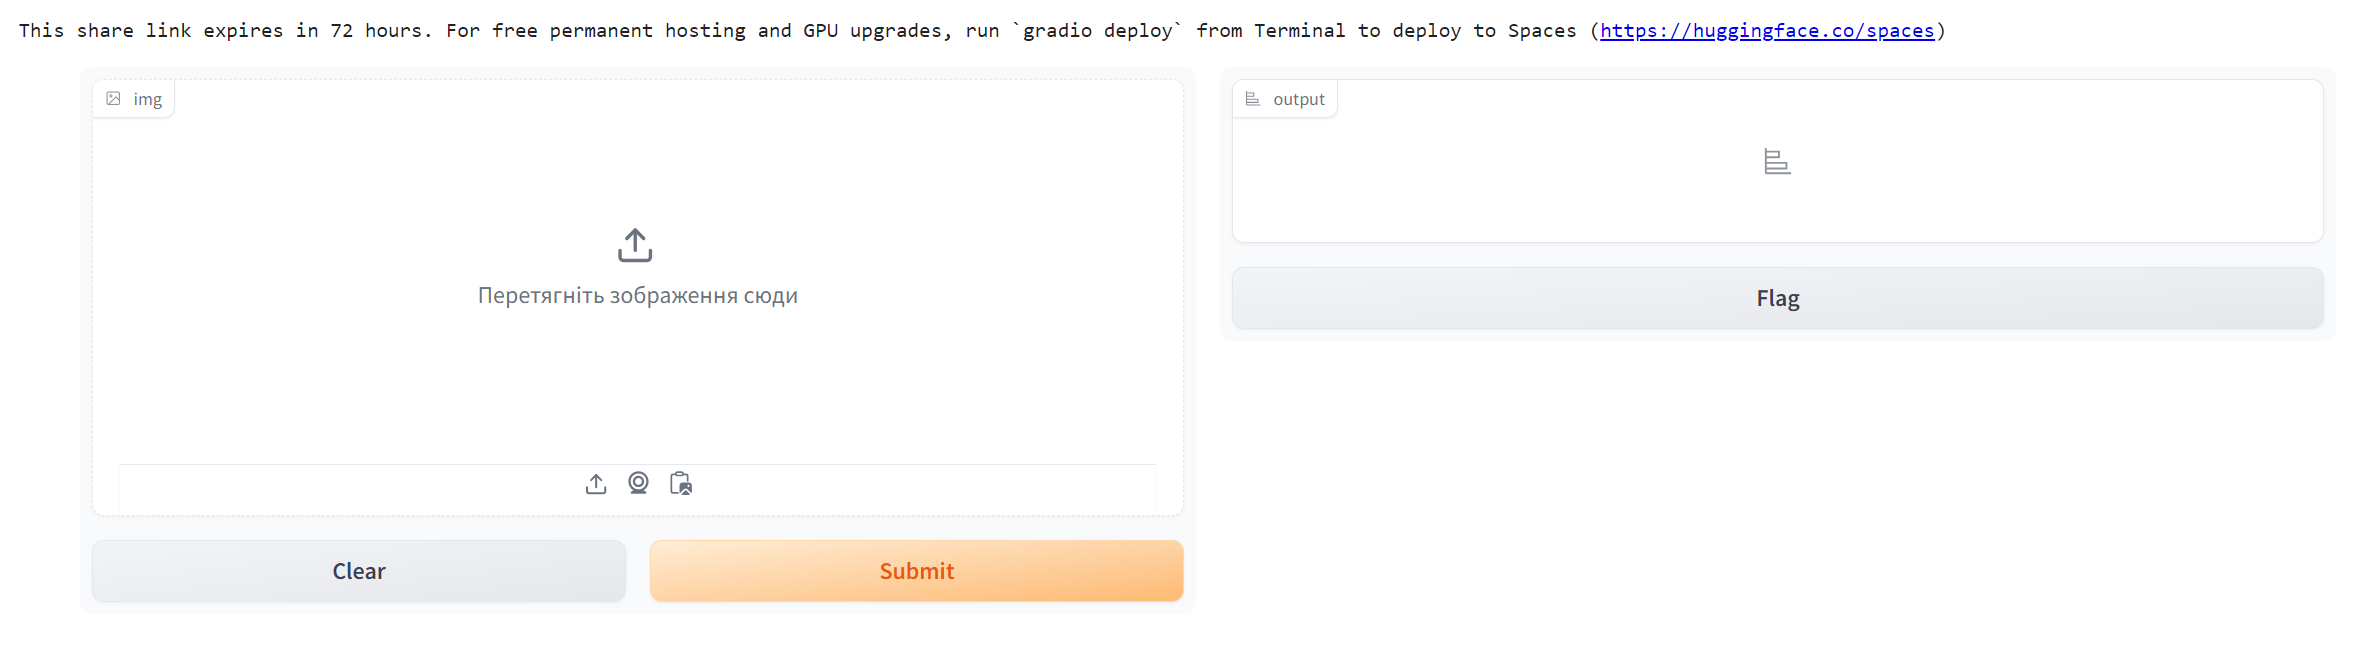

## Interface after we load some image
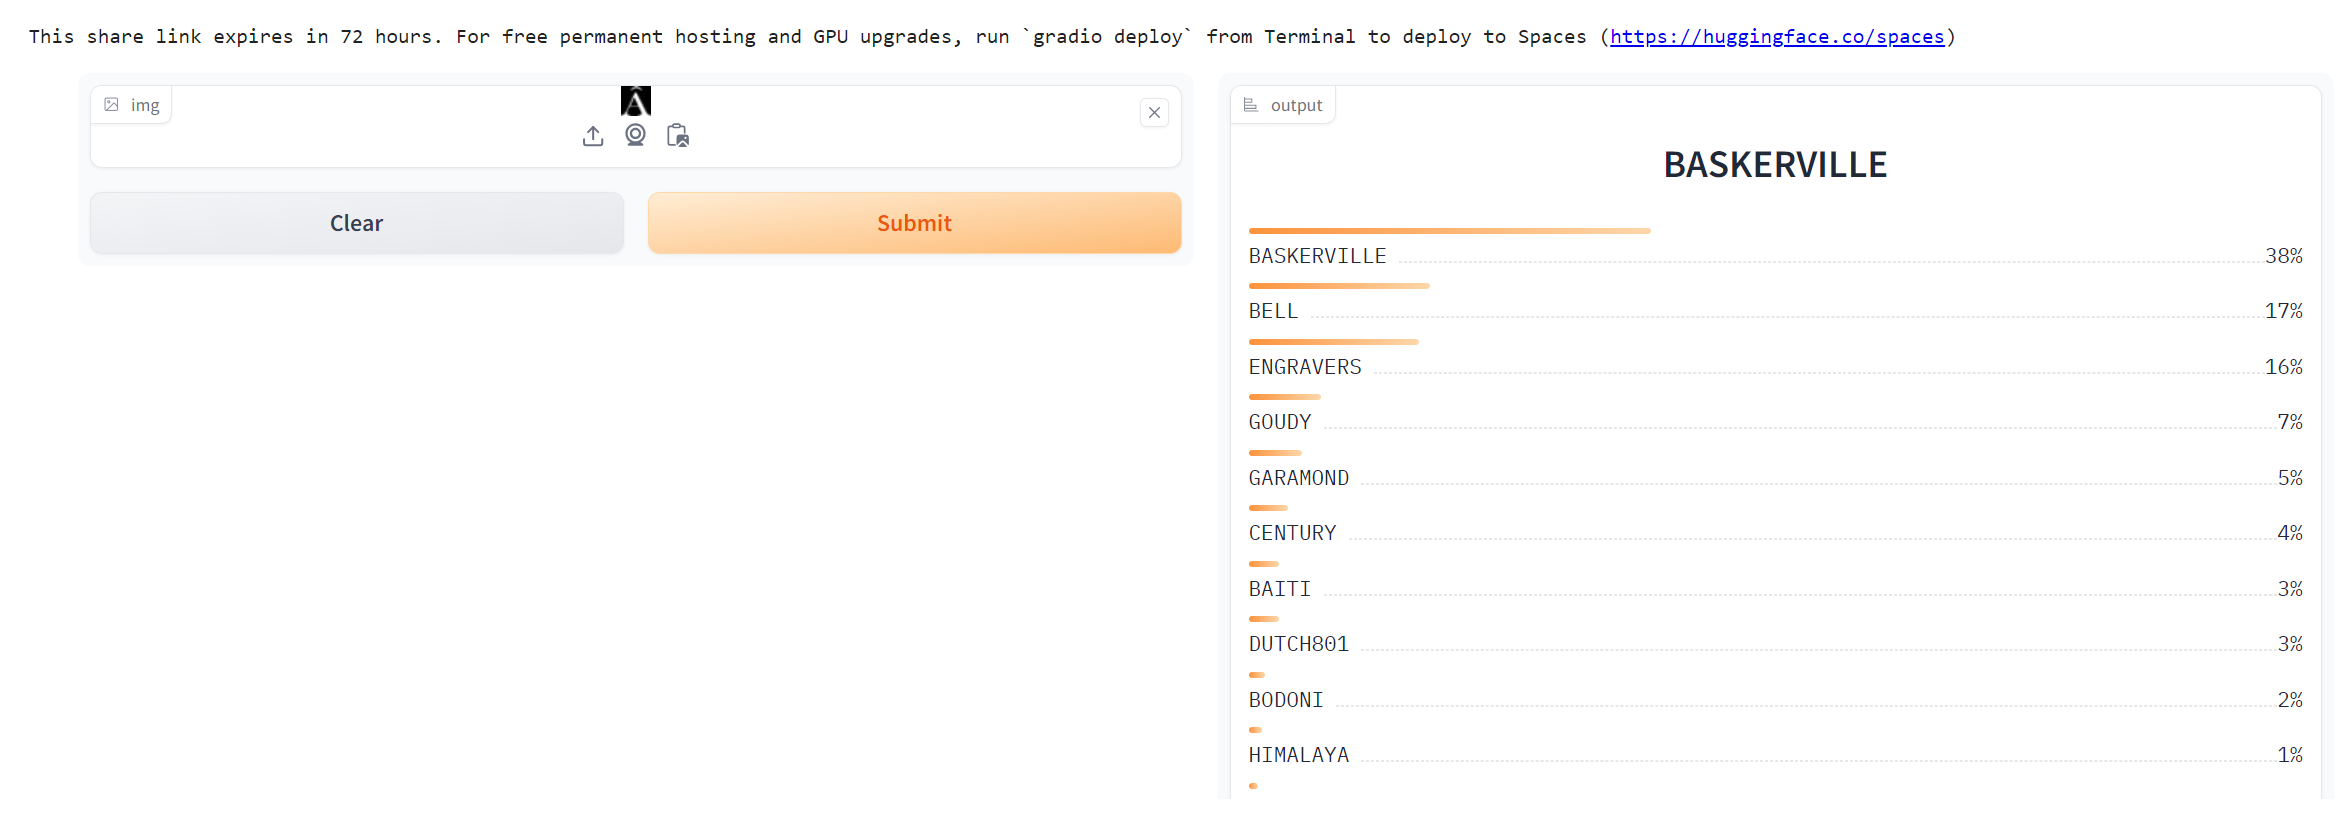